#  0. 用matplotlib找系统中字体文件大于1MB的
> 中文字体通常很大，这样过滤出的 通常有中文字体

> 结果中 看名字  'AR PL UMing CN' 果然是中文字体

In [1]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
 
for font in fonts:
    if 'CN' in font:
        print(font)

AR PL UMing CN
AR PL UKai CN


#  1. 产生tick日志

#####  编译最小main加函数1语法错误 : 文件 mini_main_f1_err.c
```cpp
//文件  mini_main_f1_err.c
char* calc_name(float age, bool high, char* nick){
  if(high && age>5){
    return "child";
  }
  char name[32]={"bigPeople"};
  return name;
}
int main(int argc, char** argv){
	calc_name(10,false,"nick");
    return 0;
}


```

```bash
tick_save=true  /pubx/build-llvm15/bin/clang-15 -c  mini_main_f1_err.c
#生成tick日志文件:
#-rw-rw-r--  137M  8月 12 08:07 clang-15_11082_1691798878973_1


```

# 2. 加载tick日志

In [2]:
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc={'figure.figsize': (30,20)}

In [3]:
import numpy 
import math

In [4]:
import seaborn

In [5]:
import plotly.offline as plotly_offline
plotly_offline.init_notebook_mode(connected=True)          
import plotly.graph_objs as graph_objs                
import plotly.figure_factory as figure_factory 

from plotly.graph_objs import Scatter, Figure, Scatter3d




> 解决 matplotlib 中文不正常显示问题，
>
> 中文显示为方块，原因是没有中文字体，
>
> 这里 将字体设置为 上面找到的中文字体 'AR PL UMing CN'

In [6]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams['font.family'] = 'AR PL UMing CN'
matplotlib.pyplot.rcParams['font.sans-serif'] = [ 'AR PL UMing CN']

In [7]:
import pandas
# pandas.options.display.max_columns = None
# pandas.options.display.max_rows = None

In [8]:
%%bash
ls -lhrt /tick_data_home/ | tail -n 1

-rw-rw-r-- 1 zz zz 137M  8月 12 08:07 clang-15_11082_1691798878973_1


In [9]:
#编译正常: mini_main.c
df=pandas.read_csv(filepath_or_buffer="/tick_data_home/clang-15_11082_1691798878973_1",sep=',' , quotechar="'")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881060 entries, 0 to 881059
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   滴答                 881060 non-null  int64 
 1   funcLocalClock     881060 non-null  int64 
 2   tickKind           881060 non-null  int64 
 3   funcEnterId        881060 non-null  int64 
 4   hasFuncCallChain   881060 non-null  int64 
 5   funcEnterIdSeqLen  881060 non-null  int64 
 6   funcEnterIdSeq     115723 non-null  object
 7   rTSVarC            881060 non-null  int64 
 8   d栈生                881060 non-null  int64 
 9   d栈死                881060 non-null  int64 
 10  d堆生                881060 non-null  int64 
 11  d堆死                881060 non-null  int64 
 12  栈生                 881060 non-null  int64 
 13  栈死                 881060 non-null  int64 
 14  栈净                 881060 non-null  int64 
 15  堆生                 881060 non-null  int64 
 16  堆死                 8

# 3. funcId 构造

In [10]:
df.head(1)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory


####  3.1 新增列 funcLoc  相当于字符串样式的funId

In [11]:
#新增列 funcLoc 
df['funcLoc']=df .apply(lambda r: f'{r.srcFile}_{r.funcLine}_{r.funcCol}', axis=1 )
df['funcLoc'].values[:4]

array(['/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_42_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_42_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_41_41',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_41_41'],
      dtype=object)

####  3.2  以 区间[0, funcLoc不重复个数-1] 作为 funcId表

In [12]:

funcLoc_values=df['funcLoc'].values
type(funcLoc_values)#numpy.ndarray
len(funcLoc_values)#1014494

funcLoc_list=list(funcLoc_values)
len(funcLoc_list)#1014494

#funcLoc转为集合
funcLoc_set=set(funcLoc_values)
len(funcLoc_set)#2838

#funcLoc集合作为列表: 即 不重复的funcLoc 列表
uqFuncLoc_Ls=list(funcLoc_set)
len(uqFuncLoc_Ls)#2838
#uq:unique

#不重复的funcLoc 列表 转为 funcId表
funcId_Tab=dict( [(fL,j) for j,fL in enumerate(uqFuncLoc_Ls)] )
list(funcId_Tab.items())[:5]

#上一版中, 此输出 源文件路径字段 左右都有粘连乱七八糟其他字符，明显是 由于使用了 已释放内存区域导致的
#这一版中，无此问题，源文件路径字段 左右很干净，说明 问题已经修复

[('/pubx/llvm-project/clang/lib/Driver/Driver.cpp_64_64', 0),
 ('/pubx/llvm-project/clang/lib/Frontend/DiagnosticRenderer.cpp_71_71', 1),
 ('/pubx/llvm-project/llvm/lib/Support/Triple.cpp_72_72', 2),
 ('/pubx/llvm-project/llvm/lib/IR/DataLayout.cpp_60_60', 3),
 ('/pubx/llvm-project/llvm/lib/Support/VersionTuple.cpp_47_47', 4)]

In [13]:

#按 funcId 查  funcLoc 表
funcId2Loc_Tab=dict( [(j,fL) for j,fL in enumerate(uqFuncLoc_Ls)] )

In [14]:
print("funcId个数:",len(funcId_Tab))

funcId个数: 1290


####  3.3  参照 funLoc列、funcId表 新增列funcId

In [15]:
#新增列 funcId 
df['funcId']=df['funcLoc'] .apply(lambda fLocJ:  funcId_Tab[fLocJ] )
df['funcId'].values[:10]
df.head(2)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,763
1,2,2,0,0,0,0,NaN,1,1,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,763


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881060 entries, 0 to 881059
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   滴答                 881060 non-null  int64 
 1   funcLocalClock     881060 non-null  int64 
 2   tickKind           881060 non-null  int64 
 3   funcEnterId        881060 non-null  int64 
 4   hasFuncCallChain   881060 non-null  int64 
 5   funcEnterIdSeqLen  881060 non-null  int64 
 6   funcEnterIdSeq     115723 non-null  object
 7   rTSVarC            881060 non-null  int64 
 8   d栈生                881060 non-null  int64 
 9   d栈死                881060 non-null  int64 
 10  d堆生                881060 non-null  int64 
 11  d堆死                881060 non-null  int64 
 12  栈生                 881060 non-null  int64 
 13  栈死                 881060 non-null  int64 
 14  栈净                 881060 non-null  int64 
 15  堆生                 881060 non-null  int64 
 16  堆死                 8

#  xx

> 文件: /pubx/clang-ctk/t_clock_tick/t_clock_tick.cpp
```cpp
/**滴答种类
 *需要被正常分析的tick是 正常tick 和 函数返回tick，
 * 正常分析不需要 函数进入tick
 * 看哪里少插入了X__funcReturn: 比对 函数进入tick    和  函数返回tick 是否配对
 */
enum TickKind{
    //正常tick
    NormalTick=0,
    //函数进入tick 可作为 和 函数返回tick 做比对，看哪里少插入了X__funcReturn
    FuncEnter=1,
    //函数返回tick
    FuncReturn=2

};
```

In [17]:
NormalTick=0
#函数进入
FuncEnter=1
#函数返回tick
FuncReturn=2

In [18]:

    


df进出=df[  df['tickKind'].isin( [FuncEnter,FuncReturn] )  ]


#代码中，只有在函数进入时，计算了链条长度 并写磁盘
df链=df[  df['tickKind'].isin( [FuncEnter] )  ]

# 函数本地时长 应 用  出时的计数器的值 
df出=df[  df['tickKind'].isin( [FuncReturn] )  ]

In [19]:
df进出.shape,  df链.shape,  df出.shape

((231446, 24), (115723, 24), (115723, 24))

In [20]:
df进出.head(5)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,763
2,3,1,1,1,1,2,444329716#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,41,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1027
4,5,1,1,2,1,3,444329716#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,526
6,7,1,1,3,1,4,444329716#3#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,181
7,8,2,2,3,0,0,NaN,0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,181


In [21]:
df链.head(5)
#多出的复数 -1616939133  应该是循环边界问题，不影响链长使用

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,763
2,3,1,1,1,1,2,444329716#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,41,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1027
4,5,1,1,2,1,3,444329716#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,526
6,7,1,1,3,1,4,444329716#3#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,181
9,10,1,1,4,1,4,444329716#4#2#1#'',0,0,0,...,2,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,45


In [22]:
df出.head(5)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
7,8,2,2,3,0,0,NaN,0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,181
11,12,3,2,4,0,0,NaN,1,0,1,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,45
17,18,2,2,6,0,0,NaN,0,0,0,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,181
21,22,3,2,7,0,0,NaN,1,0,1,...,5,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,45
30,31,12,2,5,0,0,NaN,0,0,0,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,526


In [23]:
df出.funcLocalClock.describe()

count    115723.000000
mean          7.598291
std          65.148107
min           2.000000
25%           3.000000
50%           4.000000
75%           8.000000
max       10559.000000
Name: funcLocalClock, dtype: float64

In [24]:
函数本地时长分组 = df出.groupby('funcLocalClock').size().reset_index(name='该时长的出数')

函数本地时长分组_降序 = 函数本地时长分组.sort_values(by='该时长的出数', ascending=False)
函数本地时长分组_降序.head(5)

,funcLocalClock,该时长的出数
1,3,24983
2,4,19625
0,2,14686
3,5,13398
4,6,10888


In [25]:
函数本地时长分组_降序.tail(5)

,funcLocalClock,该时长的出数
115,172,1
116,177,1
117,179,1
118,206,1
150,10559,1


过滤 函数本地时长大于1 的函数们：
- 不能用 df进出 ， 因为进入的时候 本地时长才刚刚加到1 
- 只能用 df出 ，因为此时函数执行结束了，本地时长累加完毕了

####  3.4 计算 本地时长短的函数id们

In [26]:
组_函_时最 = df出.groupby('funcId')['funcLocalClock'].max()
序组_函_时最 = 组_函_时最.sort_values(ascending=False).reset_index()
序组_函_时最.columns = ['funcId', '最大funcLocalClock']
序组_函_时最

,funcId,最大funcLocalClock
0,629,10559
1,1199,9468
2,1018,9112
3,877,8292
4,374,3639
...,...,...
1284,160,2
1285,761,2
1286,1091,2
1287,41,2


In [27]:
序组_函_时最.最大funcLocalClock.unique()

array([10559,  9468,  9112,  8292,  3639,  1413,  1350,  1151,  1131,
         526,   516,   474,   384,   355,   326,   311,   259,   238,
         206,   163,   158,   138,   131,   127,   125,   120,   112,
         109,   101,    96,    89,    86,    84,    82,    81,    79,
          77,    76,    75,    72,    64,    63,    62,    61,    58,
          57,    55,    54,    53,    51,    49,    48,    47,    46,
          45,    44,    43,    42,    41,    39,    38,    37,    36,
          35,    34,    33,    32,    31,    30,    29,    28,    27,
          26,    25,    24,    23,    22,    21,    20,    19,    18,
          17,    16,    15,    14,    13,    12,    11,    10,     9,
           8,     7,     6,     5,     4,     3,     2])

In [28]:
序组_时最_函个=序组_函_时最.groupby('最大funcLocalClock').size().reset_index()
序组_时最_函个.columns = ['最大funcLocalClock', 'funcId个数']
序组_时最_函个

,最大funcLocalClock,funcId个数
0,2,121
1,3,260
2,4,176
3,5,103
4,6,95
...,...,...
92,3639,1
93,8292,1
94,9112,1
95,9468,1


In [29]:
序组_时最_函个.head(20)
#从结果，看出来，估计要 忽略掉 函数本地执行时长 小于 7 个 滴答的  funId们

,最大funcLocalClock,funcId个数
0,2,121
1,3,260
2,4,176
3,5,103
4,6,95
5,7,72
6,8,51
7,9,54
8,10,29
9,11,20


In [30]:
序组_时最_函个.最大funcLocalClock.describe()

count       97.000000
mean       553.123711
std       1894.715047
min          2.000000
25%         26.000000
50%         53.000000
75%        125.000000
max      10559.000000
Name: 最大funcLocalClock, dtype: float64

In [31]:
时长边界=200

In [32]:
本地时短funId们=序组_函_时最[ 序组_函_时最['最大funcLocalClock'].le(时长边界) ].funcId.values.tolist()
print(len(本地时短funId们) )

1270


In [33]:
本地时长funId们=序组_函_时最[ 序组_函_时最['最大funcLocalClock'].gt(时长边界) ].funcId.values.tolist()
print(len(本地时长funId们) )

19


####  3.5  只 保留 函数本地时长 较大的 日志们

>  df进出、df链、df出 只 保留 函数本地时长 较大的

In [34]:

df进出=df进出[  df进出['funcId'].isin( 本地时长funId们 )  ]

df链=df链[  df链['funcId'].isin( 本地时长funId们 )  ]

df出=df出[  df出['funcId'].isin( 本地时长funId们 )  ]


In [35]:
df进出.shape,df链.shape,df出.shape

((15156, 24), (7578, 24), (7578, 24))

# 4 作图

In [36]:
#增大图例颜色圆球的尺寸
def inrease_g_size(g):
    for lh in g.legend_.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [500] 

In [37]:
import warnings
# 过滤掉RuntimeWarning警告
warnings.filterwarnings("ignore", category=RuntimeWarning)

###  栈生、栈净、栈死

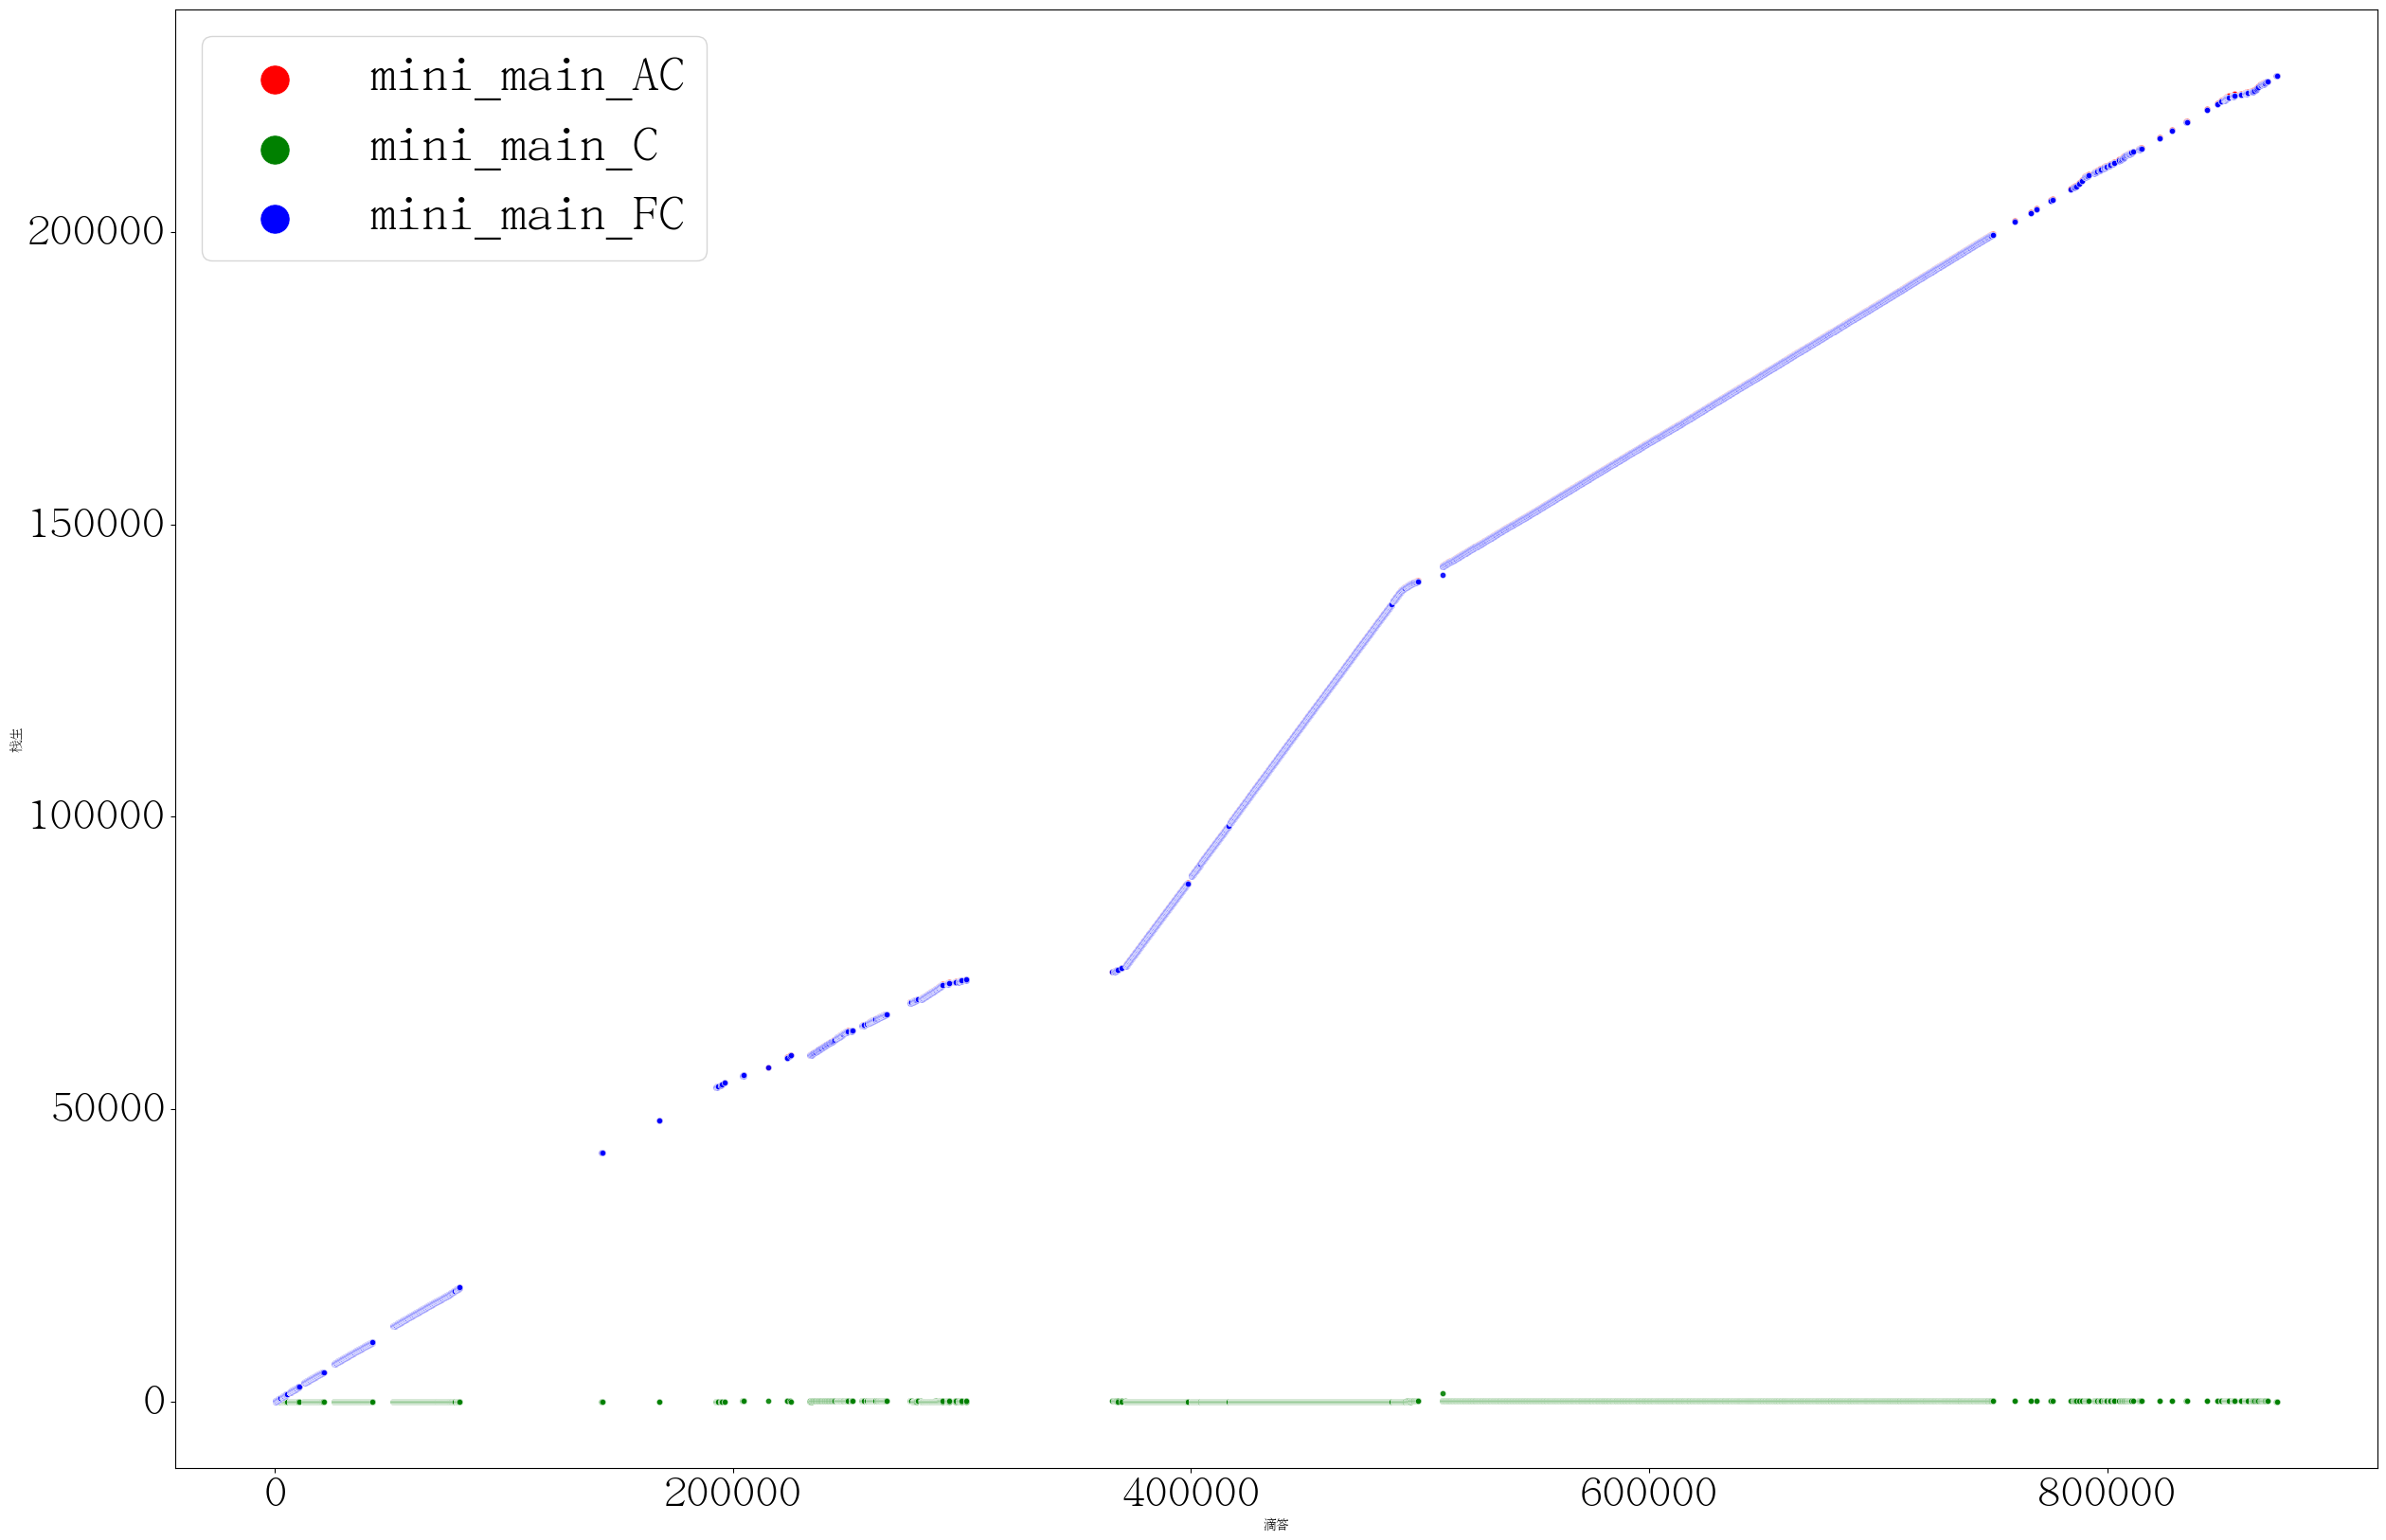

In [38]:

fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈生' , data=df进出, alpha=0.9, s=20, label='mini_main_AC',color='red',ax=ax)  
g2=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='mini_main_C',color='green',ax=ax)   
g3=seaborn.scatterplot(x='滴答', y='栈死' , data=df进出, alpha=0.9, s=20, label='mini_main_FC',color='blue',ax=ax)   

inrease_g_size(g1)
inrease_g_size(g2)
inrease_g_size(g3)

###  栈净、链长

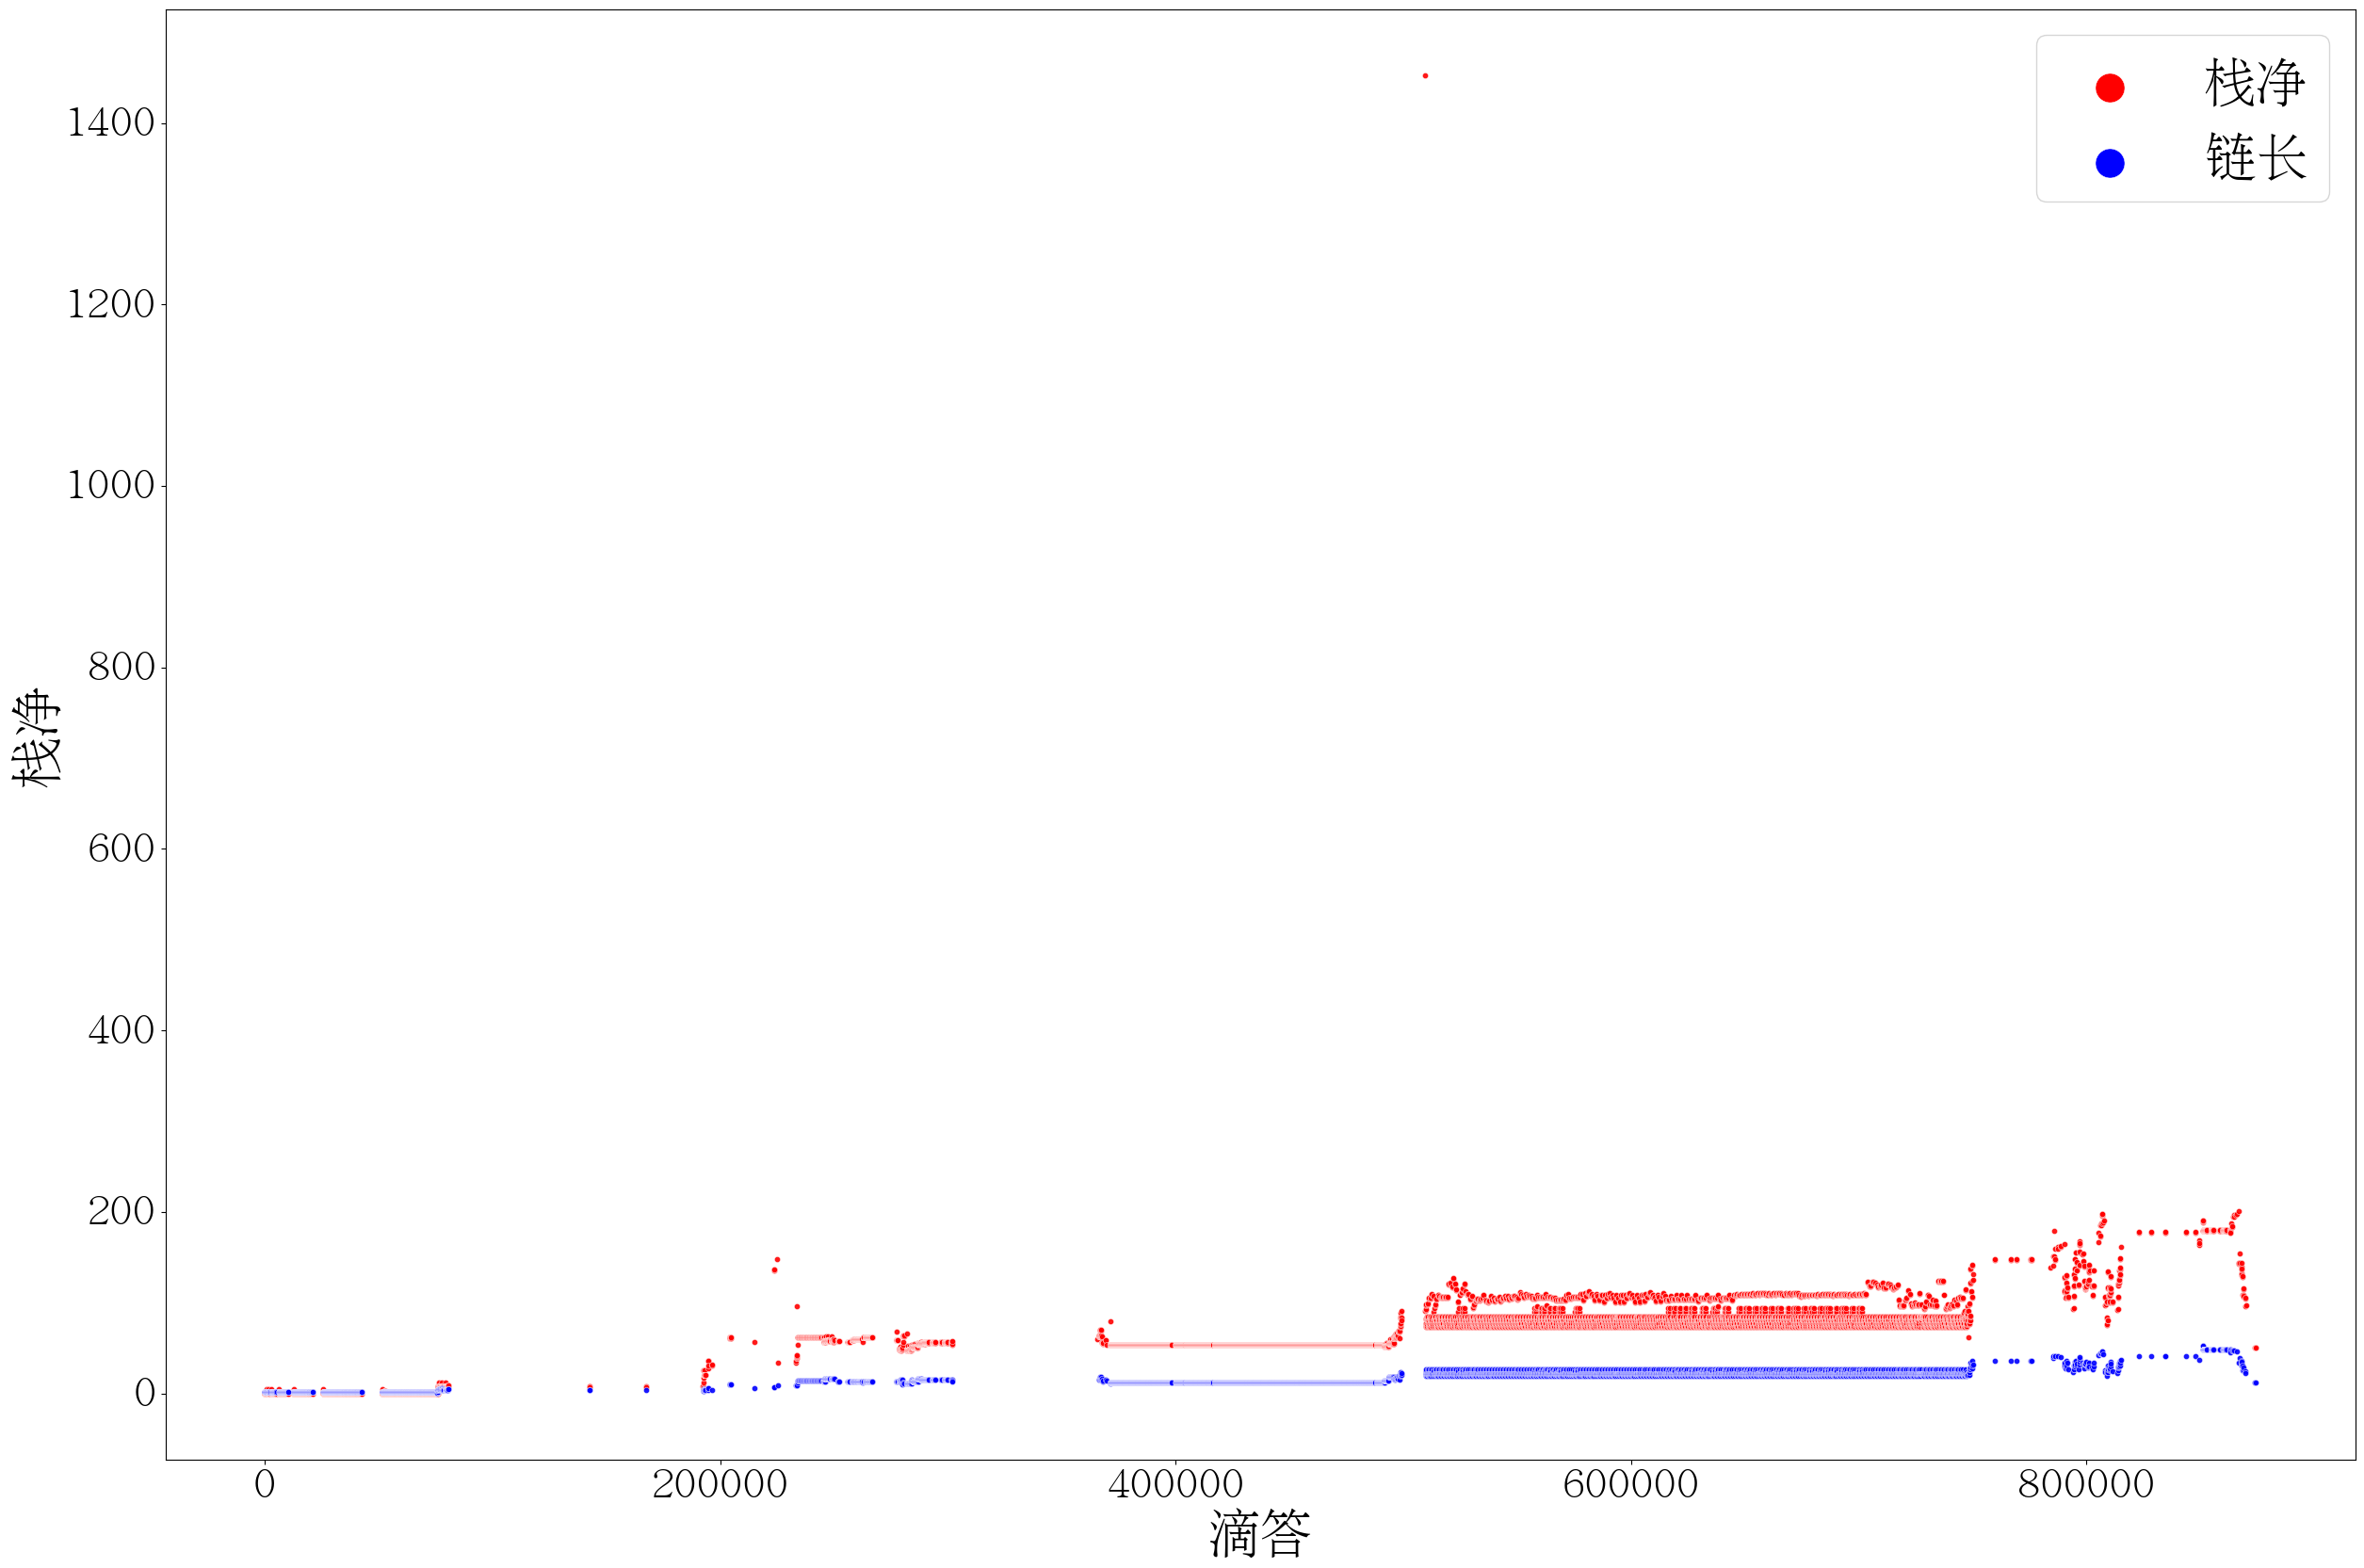

In [39]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='栈净',color='red',ax=ax)  
g2=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

###  栈净对数、链长

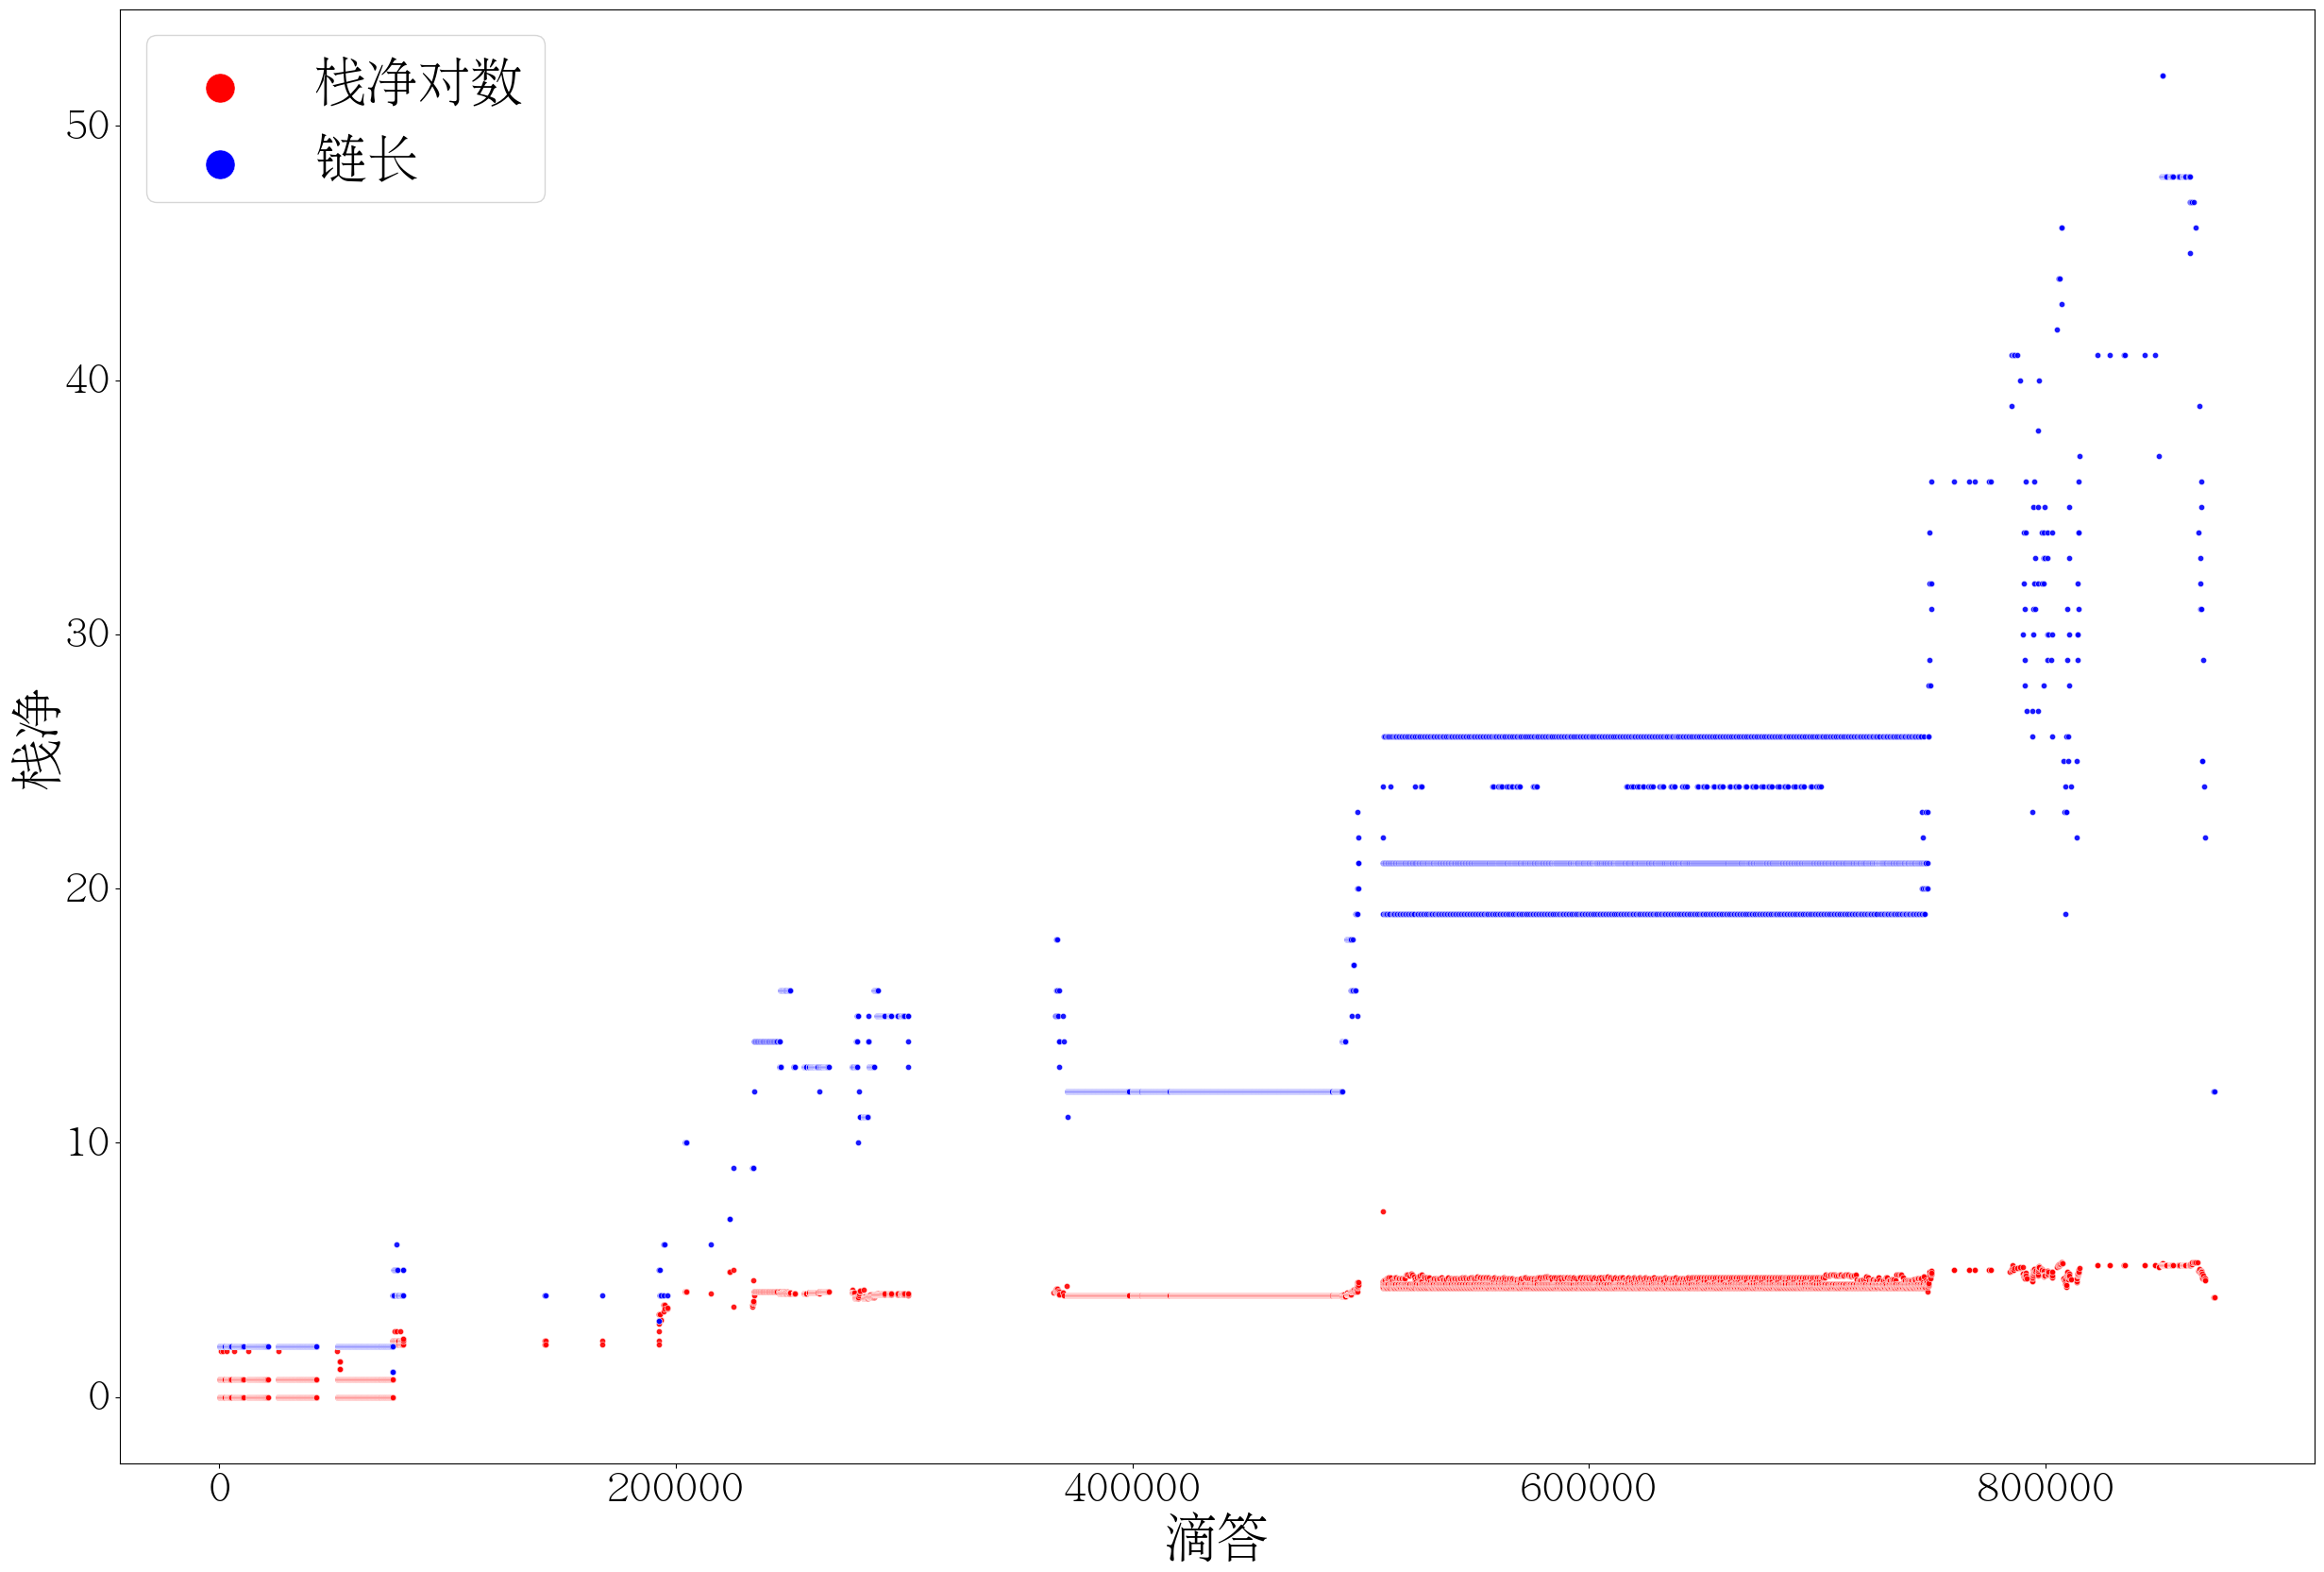

In [40]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y=numpy.log(df进出['栈净']+1) , data=df进出, alpha=0.9, s=20, label='栈净对数',color='red',ax=ax)  
g2=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

###  栈净对数、链长折线

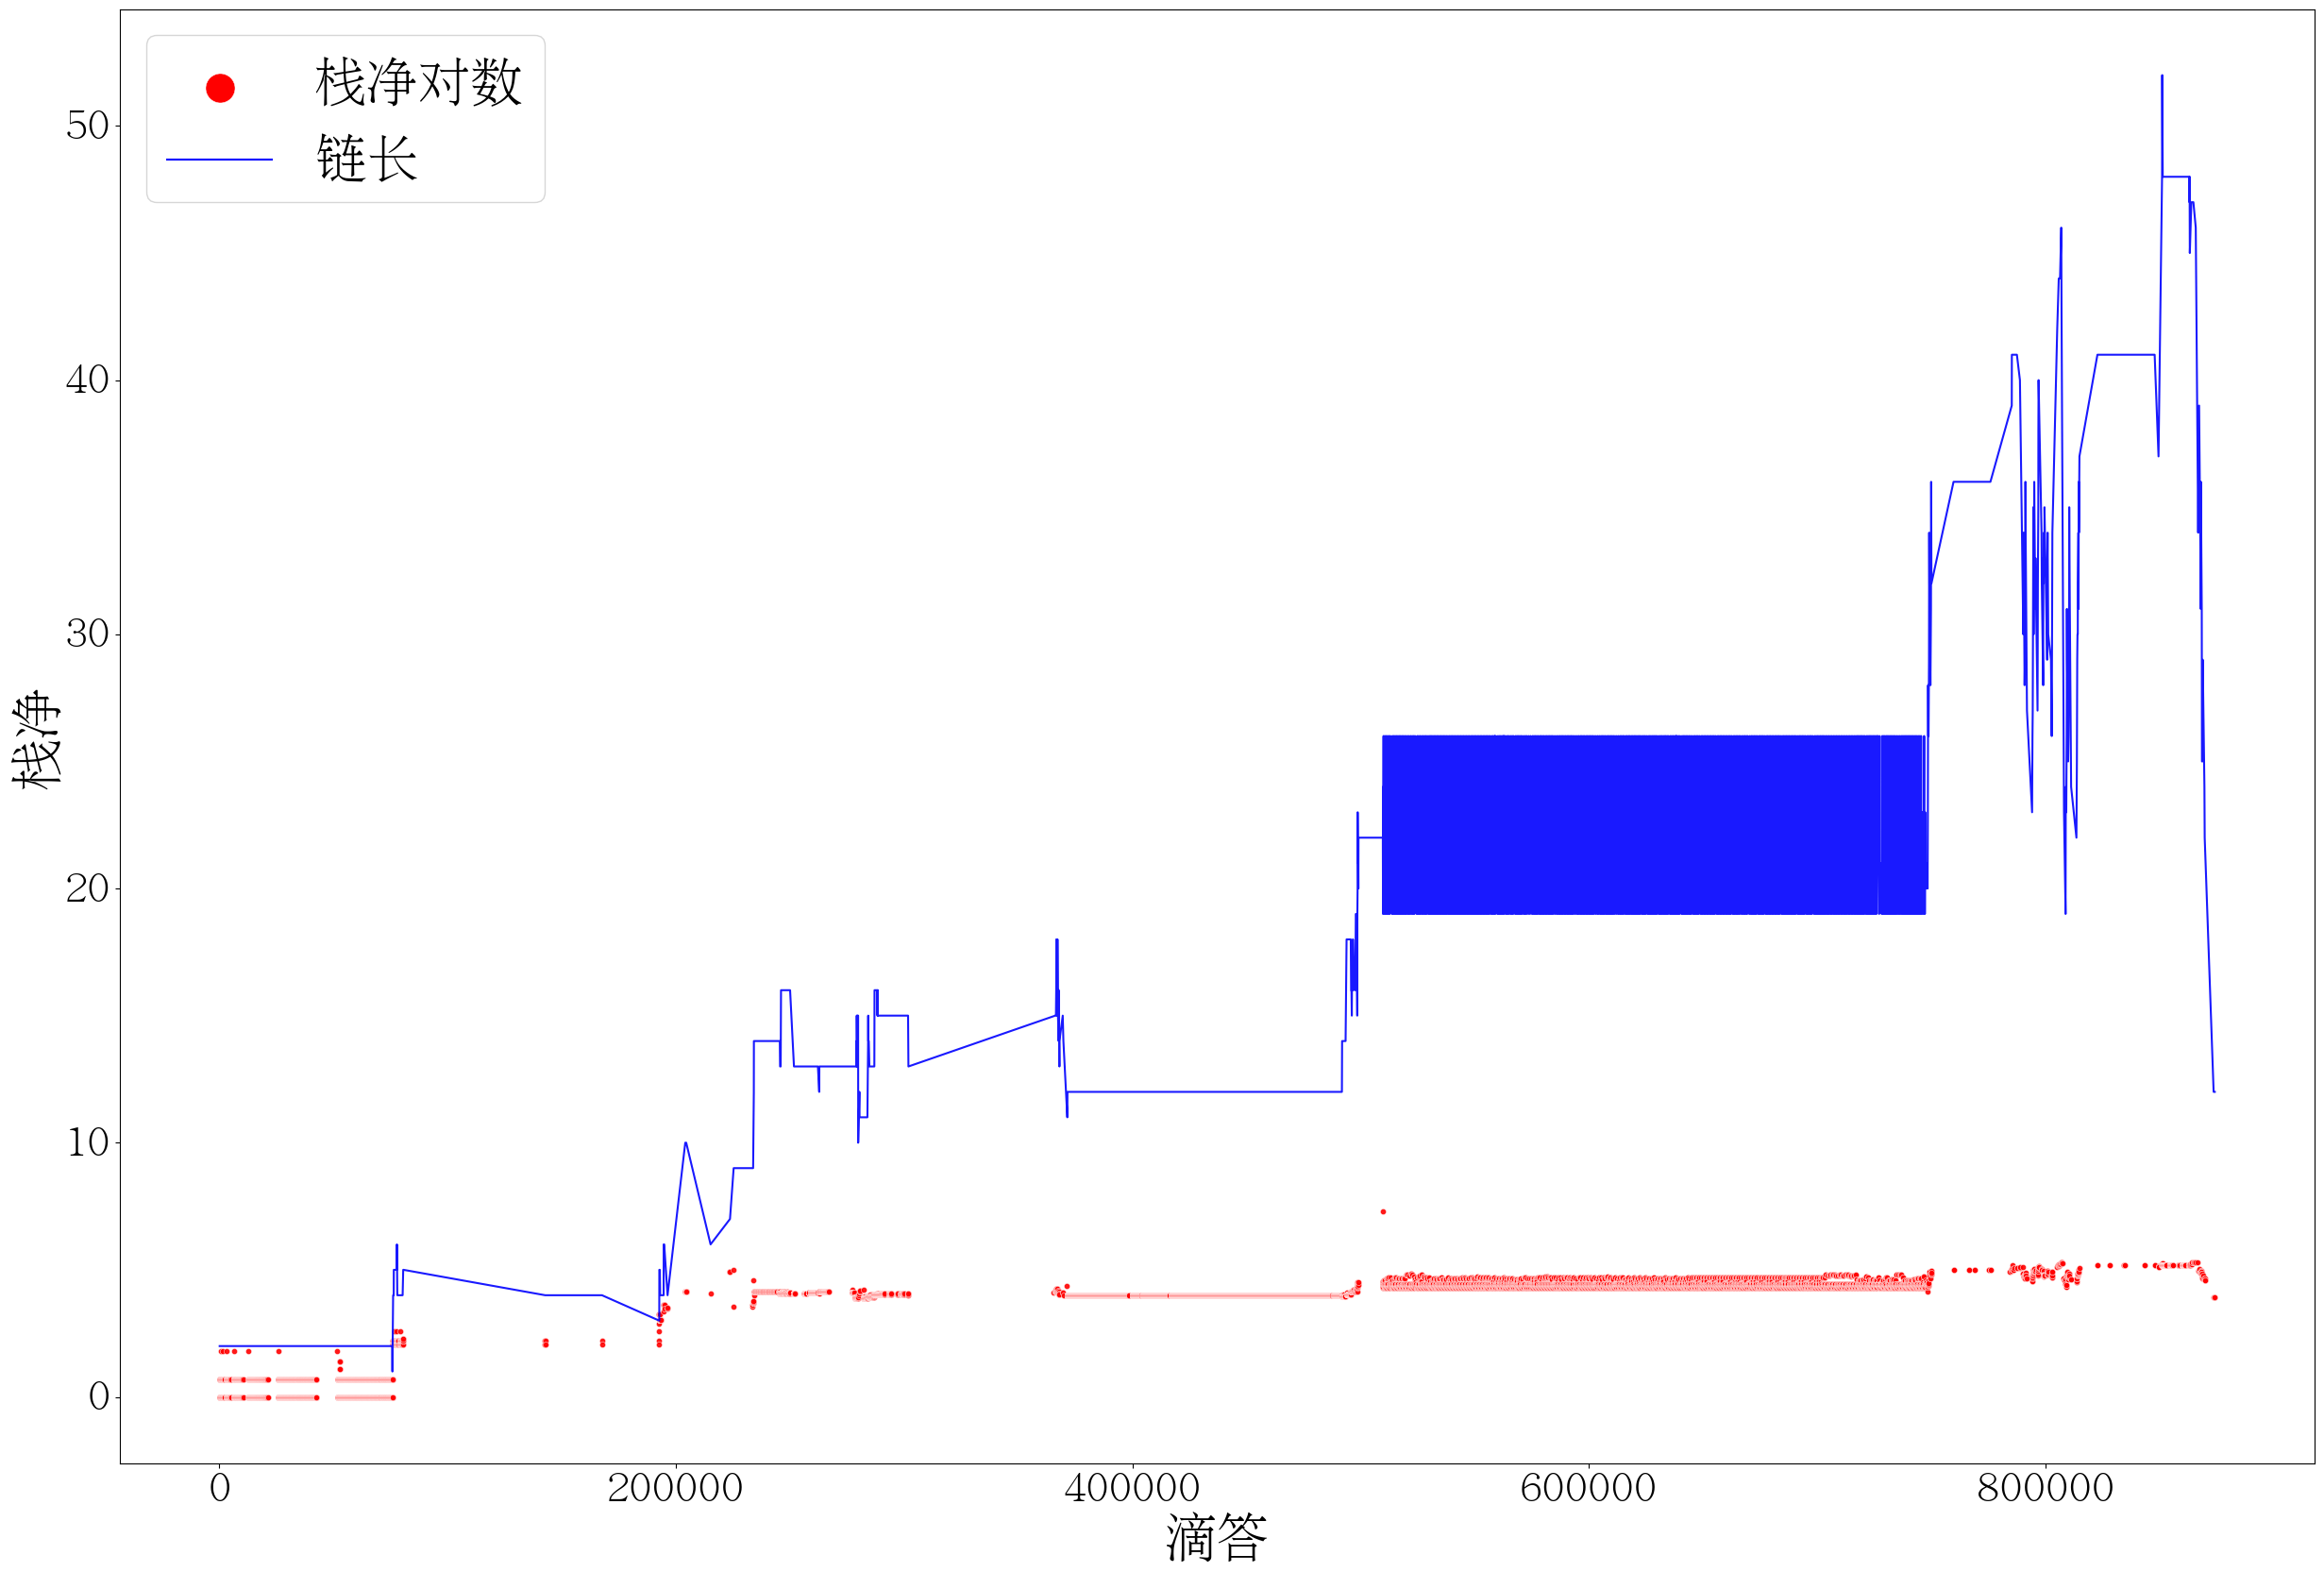

In [41]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y=numpy.log(df进出['栈净']+1) , data=df进出, alpha=0.9, s=20, label='栈净对数',color='red',ax=ax)  
g2=seaborn.lineplot(x=df链.滴答, y=df链.funcEnterIdSeqLen, alpha=0.9,  label='链长',color='blue',ax=ax)  

inrease_g_size(g1)
inrease_g_size(g2)

###  栈净

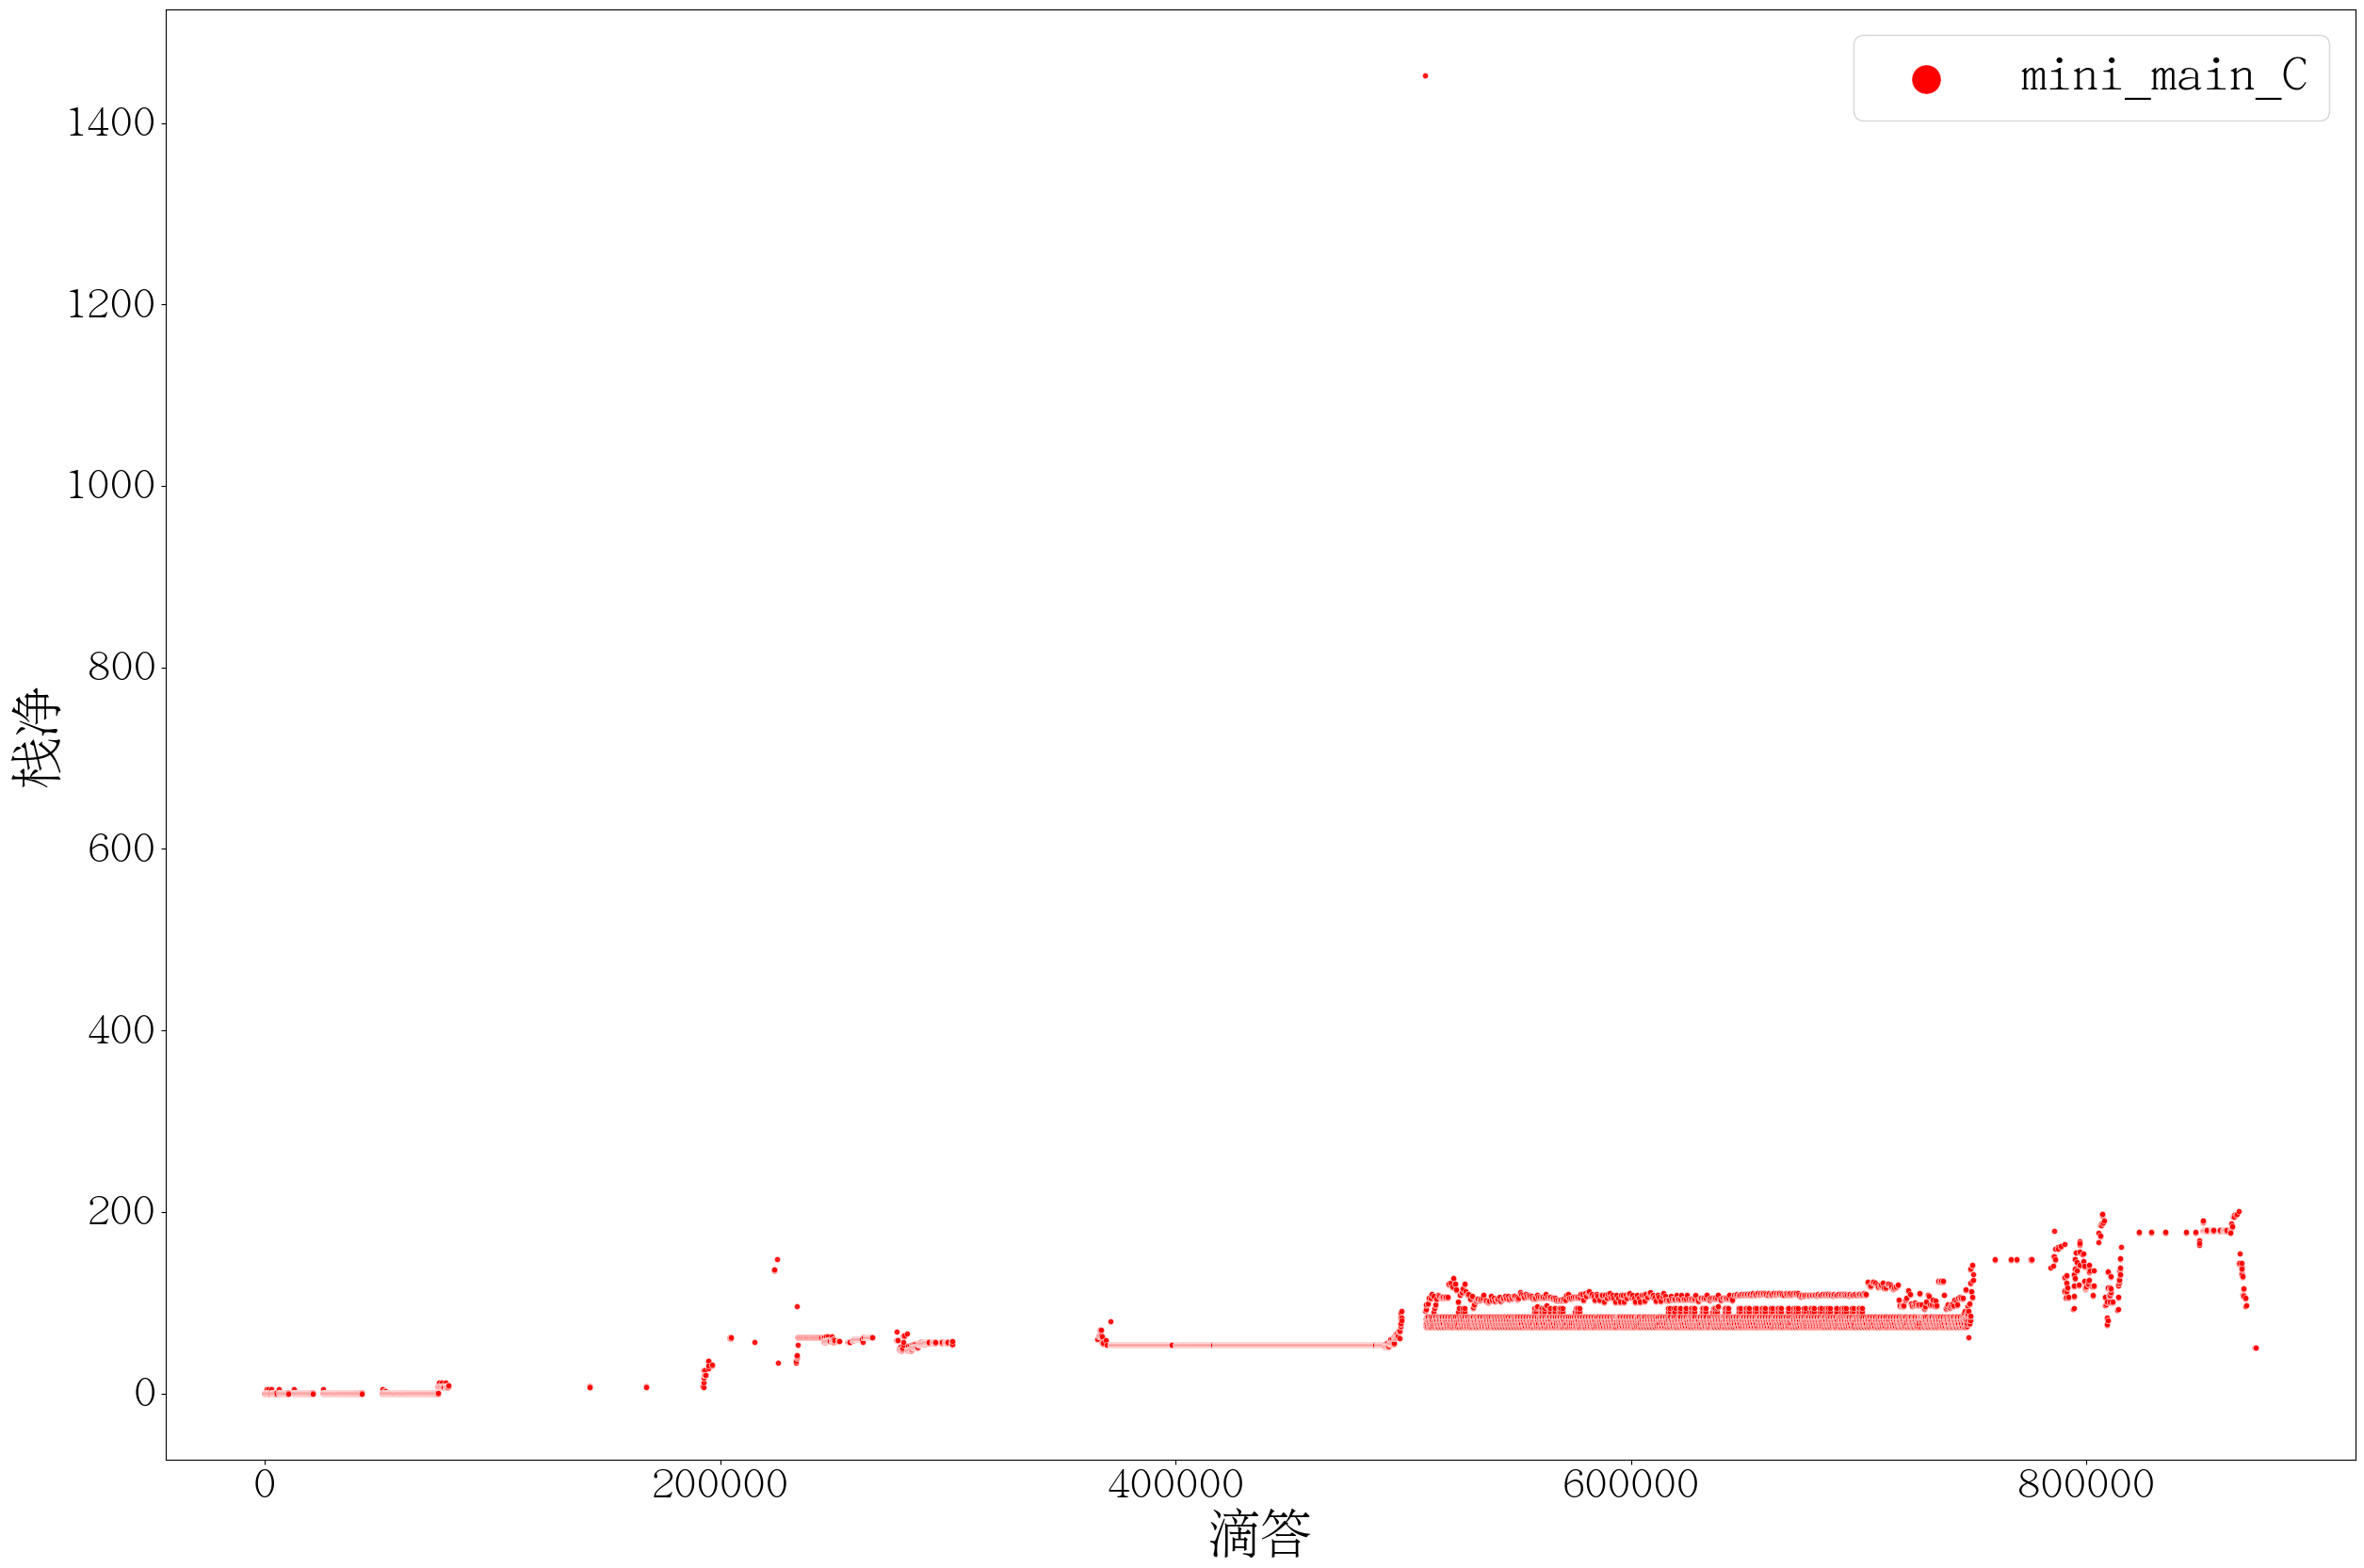

In [42]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='mini_main_C',color='red',ax=ax)  

inrease_g_size(g1)

###  链长

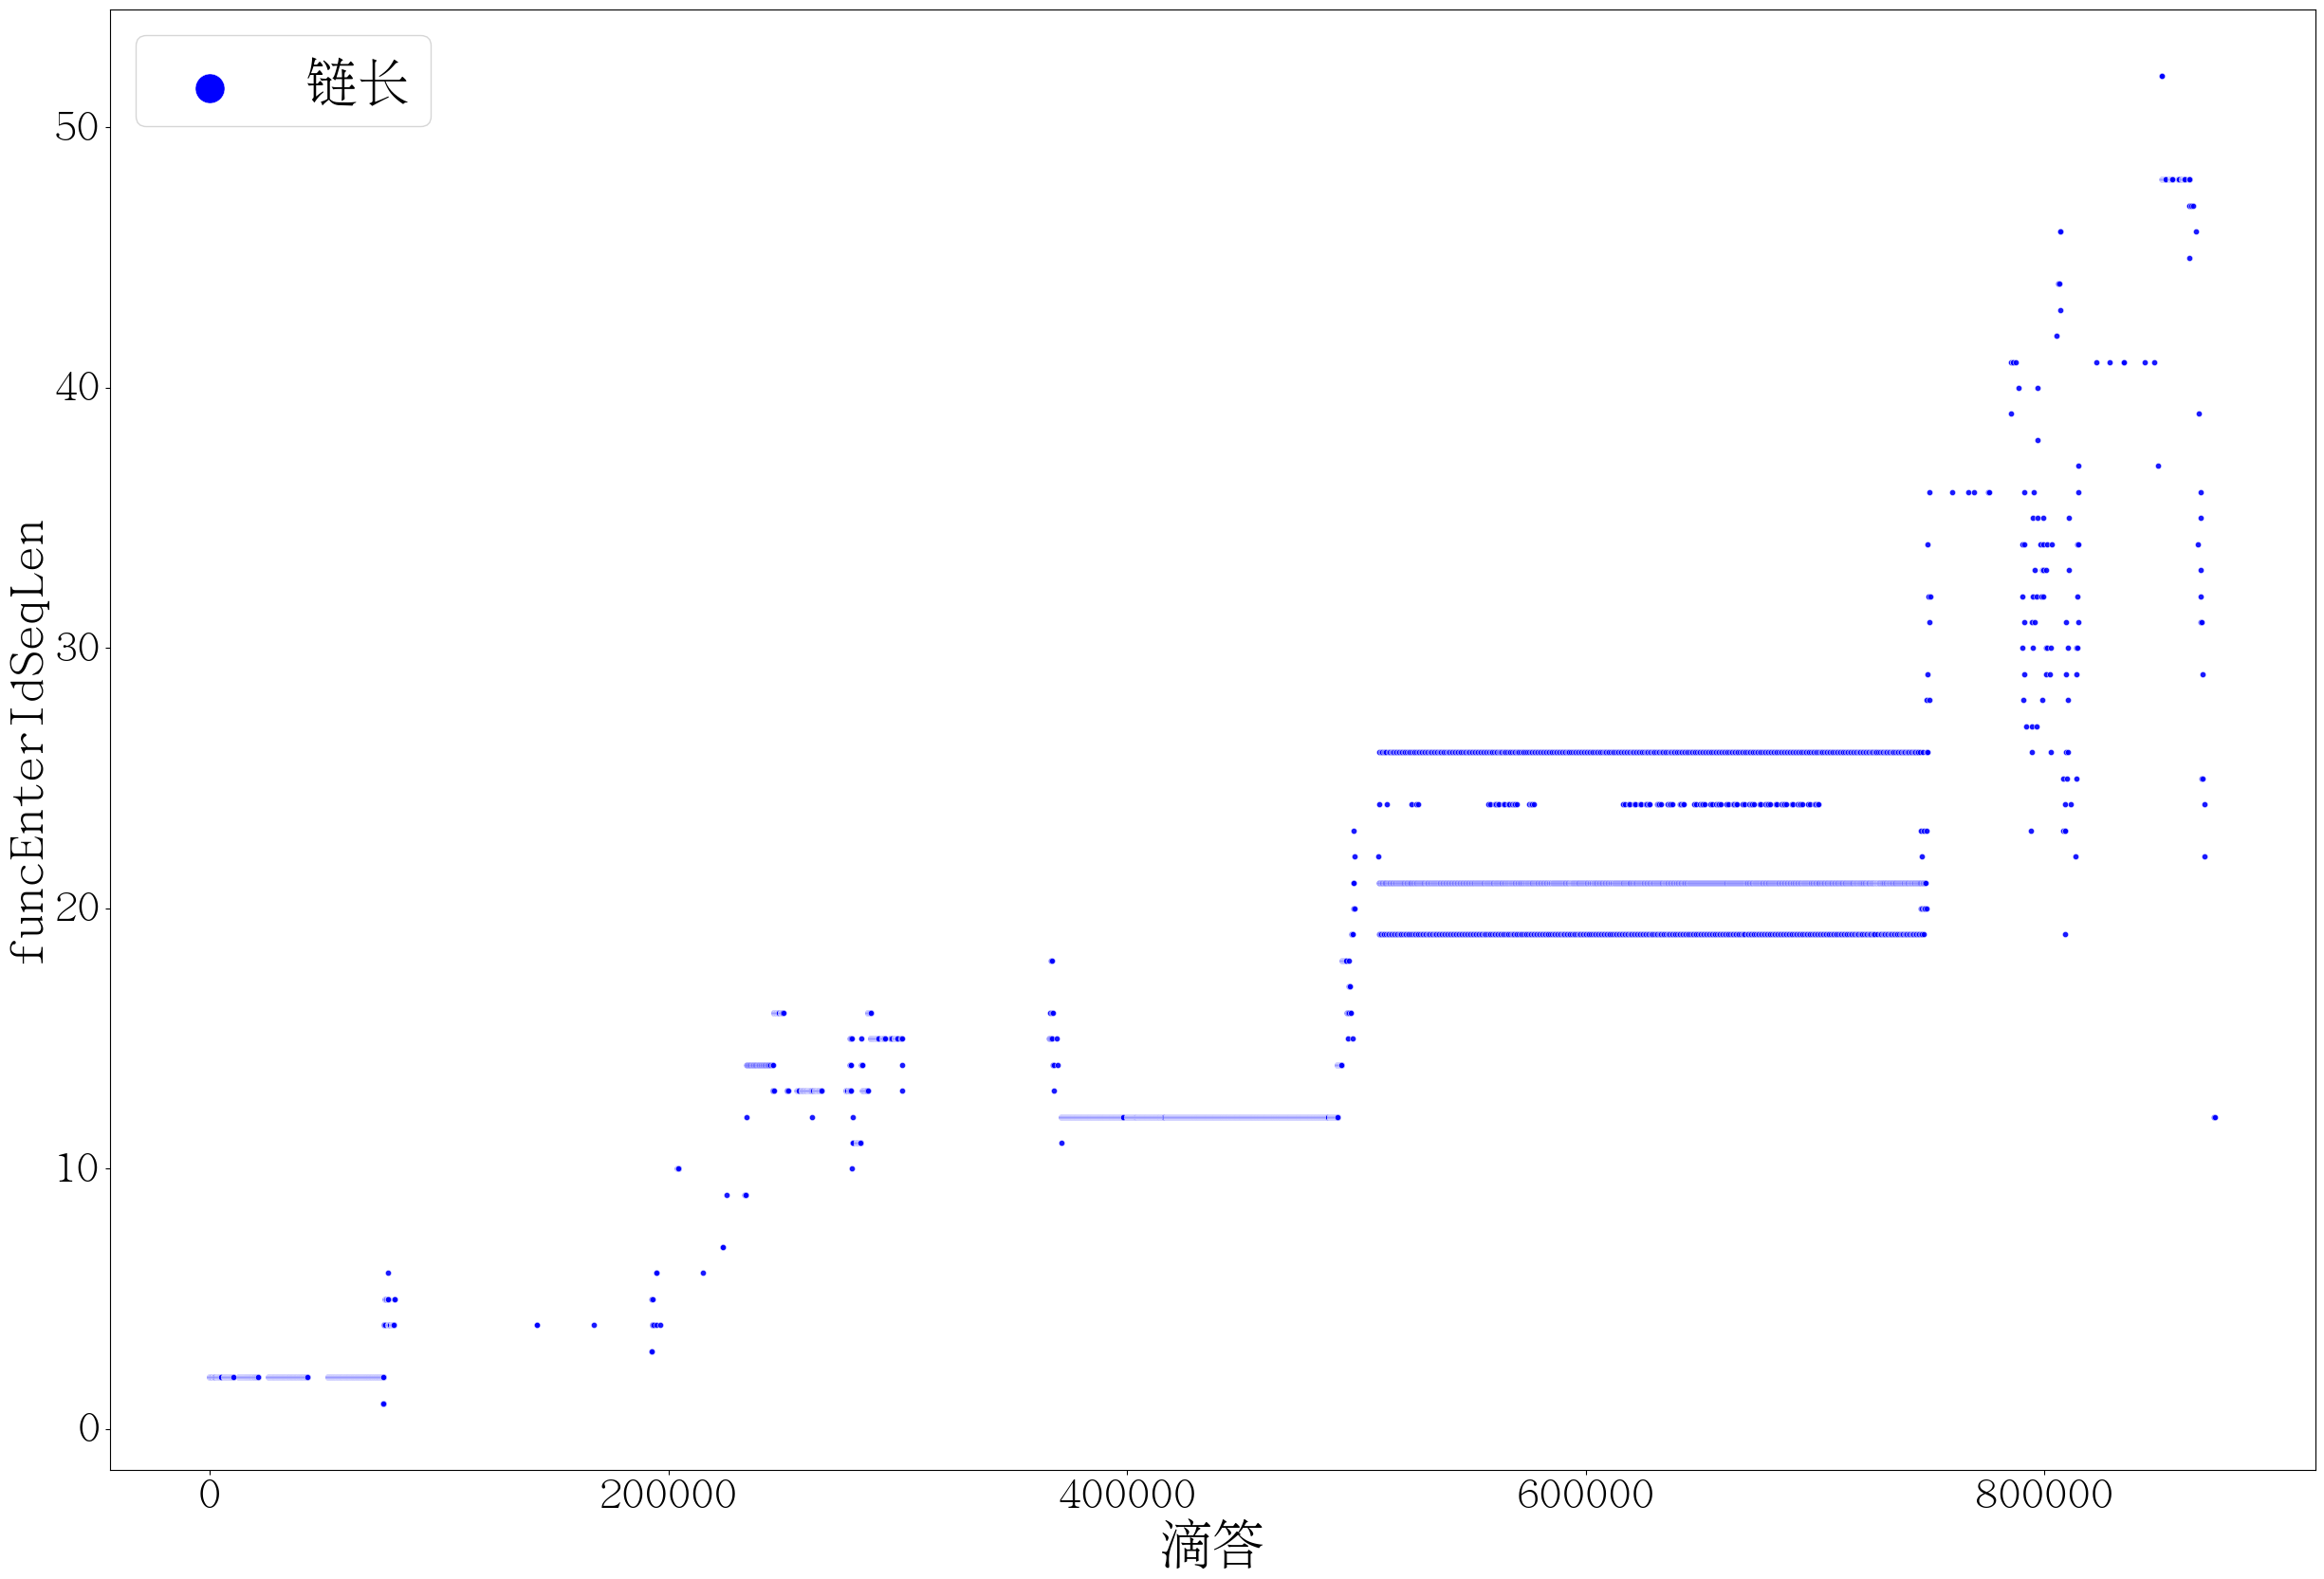

In [43]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)

##  打印长时函数、短时函数列表

In [44]:
时长边界

200

In [45]:
list( df[df.funcId.isin(本地时长funId们)].funcName.unique() )

#注意: 
# 上一个分析：mini_main_f1_ok.c  语法正确，正常编译
# 本分析：   mini_main_f1_err.c 带有语法错误，编译报错

# 下面输出的 方法 clang::TextDiagnostic::emitSnippet  :
#    在   上一个分析：mini_main_f1_ok.c 中没有， 
#    而在 本分析:    mini_main_f1_err.c 中有.

# 这很明显表明  该方法emitSnippet可能用于错误处理

['llvm::StringMapImpl::RehashTable',
 'llvm::opt::OptTable::OptTable',
 'llvm::opt::OptTable::addValues',
 'llvm::cl::ExpandResponseFiles',
 'llvm::opt::OptTable::ParseArgs',
 'isInput',
 'normalizeSimpleFlag',
 'clang::driver::tools::Clang::ConstructJob',
 'shouldEnableVectorizerAtOLevel',
 '(anonymous namespace)::CommandLineParser::ResetAllOptionOccurrences',
 'clang::CompilerInvocation::ParseCodeGenArgs',
 '(anonymous namespace)::CommandLineParser::ParseCommandLineOptions',
 'InitializePredefinedMacros',
 'clang::SourceManager::createFileID',
 'clang::SourceManager::getOrCreateContentCache',
 'llvm::DataLayout::parseSpecifier',
 'clang::Builtin::Context::initializeBuiltins',
 'clang::Lexer::Lexer',
 'clang::Preprocessor::Lex',
 'clang::Lexer::LexStringLiteral',
 'clang::SourceManager::getPresumedLoc',
 'clang::SrcMgr::LineOffsetMapping::get',
 'clang::Sema::makeTypoCorrectionConsumer',
 'clang::SourceManager::getBufferData',
 'byteToColumn',
 'columnToByte',
 'clang::TextDiagnostic:

In [46]:
list ( df[df.funcId.isin(本地时短funId们)].funcName.unique() )
#仔细看，会发现有很多 ::get* 函数， 这种命名显然是函数代码内容很短，所有说他们执行时间短 是有道理的

['llvm::cl::getGeneralCategory',
 'llvm::cl::OptionCategory::registerCategory',
 'llvm::ManagedStaticBase::RegisterManagedStatic',
 'llvm::llvm_is_multithreaded',
 'getManagedStaticMutex',
 'llvm::cl::Option::setArgStr',
 'llvm::cl::Option::addArgument',
 'llvm::StringMapImpl::LookupBucketFor',
 'llvm::StringMapImpl::init',
 'createTable',
 'getHashTable',
 'llvm::allocate_buffer',
 'llvm::RegisterBank::RegisterBank',
 'llvm::cl::AddLiteralOption',
 'llvm::SmallVectorBase::grow_pod',
 'getNewCapacity',
 'llvm::DebugCounter::instance',
 'llvm::BranchProbability::BranchProbability',
 'llvm::MCFragment::MCFragment',
 'llvm::PassRegistry::getPassRegistry',
 'llvm::PassRegistry::registerPass',
 'llvm::Regex::Regex',
 'readRequiredParams',
 'clang::ento::CallDescription::CallDescription',
 '(anonymous namespace)::getExpectedProducerName',
 '(anonymous namespace)::SegmentInjection::SegmentInjection',
 'clang_main',
 'clang::noteBottomOfStack',
 'getStackPointer',
 'llvm::InitLLVM::InitLLVM',
